*Load packages and data:*

In [1]:
%run stdPackages.ipynb
read = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix'],
        'maps': ['Generators_Categories']}
db = dbFromWB(os.path.join(d['data'],'E1.xlsx'), read)
readSets(db)

# Exercise 1: Getting to know the ```mBasic``` model class

### Problem 1: Compute the marginal costs of operation for the five plants.

The plants pays a price (```FuelPrice```) for the fuel inputs and pays a tax (```EmissionTax```)  on the CO2 it emits. Furthermore, the plant has 'other costs' of operation (```OtherMC```). The marginal cost of operation for the five plants are then computed as:
$$\begin{align}
 mc_{id} = \text{OtherMC}_{id}+\sum_{BFt} \mu_{BFt}^{id}\left[\text{FuelPrice}_{BFt}+\text{EmissionTax}\cdot \text{EmissionIntensity}_{BFt}\right],
\end{align}$$

To compute the marginal costs of operation, we need to access four symbols: (1) ```OtherMC```, (2) ```FuelMix```, (3) ```FuelPrice```, (4) ```EmissionTax```, and (5) ```EmissionIntensity```.

*Fuel costs:* The symbols ```FuelMix``` and ```FuelPrice``` are both defined over the index ```BFt```, which represents the fuel types in the model. The ```pandas``` package thus allows us to simply multiply the two to get the following symbol defined over both [BFt, id]:

In [2]:
FuelCosts = db['FuelPrice'] * db['FuelMix']
FuelCosts

BFt      id 
Coal     id1    2.126216
         id2    0.236246
         id3         0.0
         id4         0.0
         id5         0.0
NatGas   id1    0.504624
         id2    4.541617
         id3         0.0
         id4         0.0
         id5         0.0
BioMass  id1         0.0
         id2         0.0
         id3    6.996357
         id4         0.0
         id5         0.0
Waste    id1         0.0
         id2         0.0
         id3         0.0
         id4    0.015436
         id5         0.0
dtype: object

To sum up to the index ```id``` (sum over BFt), we use the build-in ```pandas``` method groupby.sum:

In [3]:
FuelCosts = FuelCosts.groupby('id').sum()
FuelCosts

id
id1     2.63084
id2    4.777864
id3    6.996357
id4    0.015436
id5         0.0
dtype: object

*Emission costs:* The cost of emissions is the product of ```EmissionTax```, ```EmissionIntensity```, and ```FuelMix```. The ```pandas``` package allows us to simply multiply the three as well to get the costs defined over [BFt, id, EmissionType]:

In [4]:
EmissionCosts = db['FuelMix'] * db['EmissionIntensity']*db['EmissionTax']
EmissionCosts

BFt      id   EmissionType
BioMass  id1  CO2                  0.0
         id2  CO2                  0.0
         id3  CO2                  0.0
         id4  CO2                  0.0
         id5  CO2                  0.0
Coal     id1  CO2             3.016254
         id2  CO2             0.335139
         id3  CO2                  0.0
         id4  CO2                  0.0
         id5  CO2                  0.0
NatGas   id1  CO2             0.202426
         id2  CO2             1.821834
         id3  CO2                  0.0
         id4  CO2                  0.0
         id5  CO2                  0.0
Waste    id1  CO2                  0.0
         id2  CO2                  0.0
         id3  CO2                  0.0
         id4  CO2             1.735714
         id5  CO2                  0.0
dtype: object

As with fuel costs, we want to sum up to the 'id' level using the groupby method from pandas. We can confirm that ids ```id3, id5``` do not pay any taxes from CO2 emissions as they use biomass and wind:

In [5]:
EmissionCosts = EmissionCosts.groupby('id').sum()
EmissionCosts

id
id1     3.21868
id2    2.156974
id3         0.0
id4    1.735714
id5         0.0
dtype: object

Finally, we get the marginal costs from summing other costs, fuel costs, and emission costs:

In [6]:
MC = db['OtherMC']+FuelCosts+EmissionCosts
MC

id
id1    8.849521
id2    9.934837
id3    9.996357
id4    4.751151
id5         3.0
dtype: object

We can confirm that this is indeed the method implemented in ```lpModels.mc(db)```:

In [7]:
lpModels.mc(db) == MC

id
id1    True
id2    True
id3    True
id4    True
id5    True
dtype: bool

### Problem 2: Identify the marginal producer and the system marginal costs

Recall from the note on "*Models for Energy Economics*" that the marginal producer is the only one that is characterized by **an interior solution** in the sense that it produces somewhere between 0 and its generating capacity; all other plants either produce nothing or at full capacity.

We start by solving the model:

In [8]:
m = lpModels.mBasic(db) # initialize using the database 'db' from above.
m.solve() # solve the model; should return a short printed statement that optimization is succesful.

Solution status 0: Optimization terminated successfully.


Next, we compare the actual production ('Generation') to the generating capacity ('GeneratingCapacity') for the plants. One way we can do this is to define the ratio of generation to capacity, which we can also call the *degree of utilization* and look for the 'id' with a degree between [0,1]:

In [9]:
m.db['Generation'] / m.db['GeneratingCapacity']

id
id1       1.0
id2    0.8625
id3       0.0
id4       1.0
id5       1.0
dtype: object

The *marginal producer* is the ```id2``` plant that relies primarily on natural gas in this model. As this is the marginal producer, we know that the system marginal costs is given by the marginal cost of ```id2```. Thus, the system marginal cost is in this case $9.93$ EUR/GJ (see print below)

In [10]:
m.db['mc']

id
id1    8.849521
id2    9.934837
id3    9.996357
id4    4.751151
id5         3.0
dtype: object

### Problem 3: A shock to tax on CO2 emissions

We start by storing the results from the first solution:

In [11]:
db_BeforeShock = m.db.copy()

Next, we set the tax on CO2 emissions to 50 EUR instead, re-compute the marginal costs, re-solve, and store a copy of this solution:

In [12]:
m.db['EmissionTax'] = 50
m.solve(preSolve = {'recomputeMC':True})
db_50Euro = m.db.copy()

Solution status 0: Optimization terminated successfully.


And repeat this for the case of 100 EUR:

In [13]:
m.db['EmissionTax'] = 100
m.solve(preSolve = {'recomputeMC':True})
db_100Euro = m.db.copy()

Solution status 0: Optimization terminated successfully.


We can then compare emissions e.g. by plotting the three. The syntax used here uses another feature of the ```pandas``` package, namely that pandas objects can be plotted by simply adding ```.plot```:

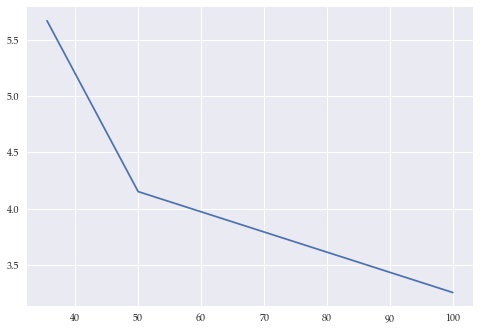

In [14]:
results = pd.DataFrame({db_BeforeShock['EmissionTax'][0]: db_BeforeShock['Emissions'], 
                        db_50Euro['EmissionTax'][0] : db_50Euro['Emissions'],
                        db_100Euro['EmissionTax'][0]: db_100Euro['Emissions']}).stack().xs('CO2')
results.plot();

Not surprisingly, emissions decrease when the tax on emissions increase. The largest effect is seen when increasing the tax from the original $35$ EUR/Tonnes CO2 to $50$.

We can see why this is the case by inspecting the variable 'FuelConsumption' in the three instances:

In [15]:
results = pd.DataFrame({db_BeforeShock['EmissionTax'][0]: db_BeforeShock['FuelConsumption'], 
                        db_50Euro['EmissionTax'][0] : db_50Euro['FuelConsumption'],
                        db_100Euro['EmissionTax'][0]: db_100Euro['FuelConsumption']})
results

,35.513339,50.000000,100.000000
BFt,,,
Coal,30.45,27.95,3.95
NatGas,34.05,11.55,35.55
BioMass,0.0,25.0,25.0
Waste,20.125,20.125,20.125


* We can see that when the tax increases from $35$ to $50$, a lot of the natural gas production is replaced by biomass; this has a large effect on emissions.
* When the tax increases from $50$ to $100$, we instead see that natural gas replaces coal; this has a smaller impact on emissions as natural gas still emits some CO2.

### Problem 4: Abating emissions using wind power

First, we reset the price of emissions to the original level.

In [16]:
m.db = db_BeforeShock

First, create the loop object with 41 gridpoints:

In [17]:
loop = pd.Index(range(41), name = 'loop')

Second, create the grid with parameter values to use. In this case, the parameter ```GeneratingCapacity``` should be updated from 10 to 50, but only for the id ```id5``` (this plant represents wind power). A fast way to do this is the function ```addGrid``` which takes as inputs the initial and final value in the relevant grid:

In [18]:
v0 = pd.Series(10, index = pd.Index(['id5'], name = 'id'))
vT = pd.Series(50, index = pd.Index(['id5'], name = 'id'))
windGrid = addGrid(v0,vT,loop,'GeneratingCapacity') # inputs are (1) first value in grid, (2) final value, (3) loop, (4) name of symbol
windGrid

loop  id 
0     id5    10.0
1     id5    11.0
2     id5    12.0
3     id5    13.0
4     id5    14.0
5     id5    15.0
6     id5    16.0
7     id5    17.0
8     id5    18.0
9     id5    19.0
10    id5    20.0
11    id5    21.0
12    id5    22.0
13    id5    23.0
14    id5    24.0
15    id5    25.0
16    id5    26.0
17    id5    27.0
18    id5    28.0
19    id5    29.0
20    id5    30.0
21    id5    31.0
22    id5    32.0
23    id5    33.0
24    id5    34.0
25    id5    35.0
26    id5    36.0
27    id5    37.0
28    id5    38.0
29    id5    39.0
30    id5    40.0
31    id5    41.0
32    id5    42.0
33    id5    43.0
34    id5    44.0
35    id5    45.0
36    id5    46.0
37    id5    47.0
38    id5    48.0
39    id5    49.0
40    id5    50.0
Name: GeneratingCapacity, dtype: float64

Third, we specify which symbols we want to solve for and store in the loop. In this exercise, we want to plot what happens to 'Emissions' and 'FuelConsumption':

In [19]:
extract = ['FuelConsumption','Emissions']

We run the experiment using the ```loopSolvExtract``` method:

In [20]:
solution = m.loopSolveExtract(loop,[windGrid],extract)

We can now plot emissions by simply writing:

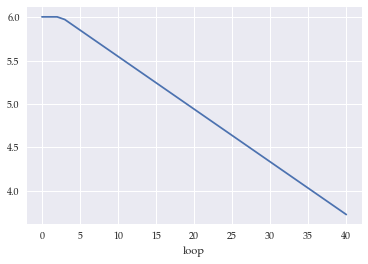

In [21]:
solution['Emissions'].xs('CO2').plot(figsize=(6,4));

And plot fuel consumption by writing (unstacking results in multiple lines in the figure):

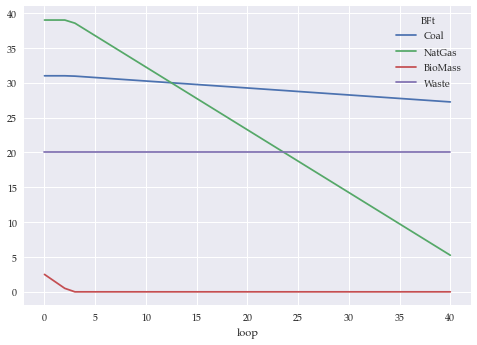

In [22]:
solution['FuelConsumption'].unstack(level='BFt').plot();

**Comments on the solution:**
* Initially, wind power crowds out electricity generated using biomass. This has no effect on emissions.
* As more wind power is installed, the next technology that it crowded out is the plant that relies primarily on natural gas.
* In this scenario, using renewable energy shares (RES) as an instrument to abate emissions is not very effective; the dirtiest of production technologies - coal - is barely reduced at all. 